# Maps for Genna

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm

import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 14

In [3]:
# Load ETOPO1 as netCDF
topo = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/bathymetry/ETOPO1_Bed_g_gmt4.grd')

In [4]:
xls = pd.ExcelFile('/home/bmoorema/Desktop/LS_eNd_compilation.xlsx')

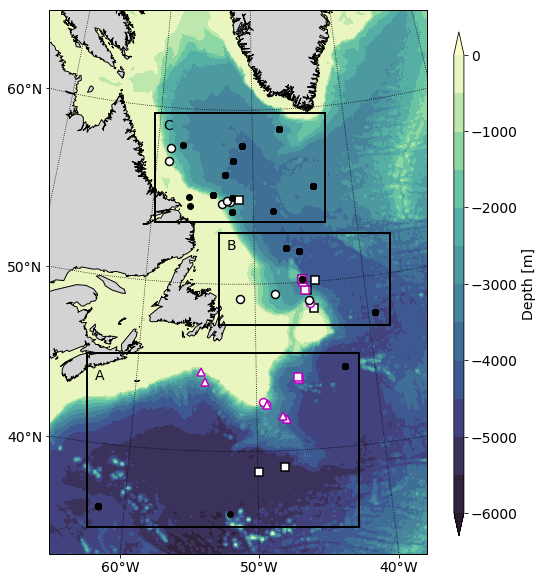

In [10]:
# Define plotting boundaries
xbound, ybound = [-65, -38], [33, 65] # Sets the projection extent
xlim, ylim = [-80, -10], [30, 80]     # Sets the gridline and bathymetry extent (needs to be larger because of conic)

# Make projection and coastlines
fig, ax = plt.subplots(figsize=(7, 10), subplot_kw={'projection': crs.LambertConformal(np.mean(xbound), np.mean(ybound))})
cax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
ax.set_extent(xbound + ybound)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='lightgray'))
fig.canvas.draw()

# Add bathymetry (interpolate to 0.1 deg to reduce plotting resolution)
topo_labsea = topo.interp(x=np.arange(*xlim, 0.1), y=np.arange(*ylim, 0.1))
lon, lat, depth = [topo_labsea[var].values for var in ['x', 'y', 'z']]
c = ax.contourf(lon, lat, depth, levels=range(-6000, 1, 500), cmap=cm.deep_r, extend='both', transform=crs.PlateCarree())

# Add gridlines, ticks and colorbar
xticks, yticks = [list(range(*l, 10)) for l in [xlim, ylim]]
ax.gridlines(linestyle=":", color='k', xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lct.lambert_xticks(ax, xticks)
lct.lambert_yticks(ax, yticks)
fig.colorbar(c, cax=cax, label='Depth [m]')

# Plot data locations
fields = ['Lon', 'Lat', 'Foraminifera', 'Residue', 'Seawater']
for lon, lat, foram, res, sw in zip(*[xls.parse(0)[field].values for field in fields]):
    marker = 's' if foram == 1 else 'o' if res == 1 else '^'
    ec = 'm' if sw == 1 else 'k'
    ax.plot(
        lon, lat, marker=marker, markerfacecolor='w', markeredgecolor=ec,
        markeredgewidth=1.5, markersize=8, transform=crs.PlateCarree(),
    )
    
# Plot literature locations
for lon, lat in zip(xls.parse(2).pub_lon, xls.parse(2).pub_lat):
    if lat < 60: ax.plot(lon, lat, 'ko', markerfacecolor='k', transform=crs.PlateCarree())

# Add rectangles
locs = [((0.1, 0.05), 0.72, 0.32), ((0.45, 0.42), 0.45, 0.17), ((0.28, 0.61), 0.45, 0.2)]
for loc, label in zip(locs, ['A', 'B', 'C']):
    ax.add_patch(Rectangle(*loc, color='k', linewidth=2, fill=False, transform=ax.transAxes, zorder=10))
    shift = 0.05 if label is 'A' else 0.03
    ax.text(loc[0][0] + 0.02, loc[0][1] + loc[2] - shift, label, transform=ax.transAxes)

plt.show()
fig.savefig('/home/bmoorema/Desktop/LabSea_map.pdf', bbox_inches='tight')